In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Vienna Multi-Sensor Training Pipeline</span>

## 🗒️ This notebook trains independent models for each Vienna sensor

### Pipeline Overview:
1. Load Vienna sensor configuration and feature groups
2. **For each of the 9 active sensors:**
   - Filter sensor-specific data
   - Add lagged features (PM2.5 from 1, 2, 3 days ago)
   - Create Feature View with weather + lagged features
   - Train Enhanced XGBoost model
   - Evaluate model performance (MSE, RMSE, MAE, R²)
   - Save model to Hopsworks Model Registry
   - Generate visualizations (feature importance, predictions)
3. Generate comprehensive training summary

## 🎯 Models Trained:
This notebook will train **9 independent enhanced models**, one for each sensor:
- Kendlerstraße 40
- Hausgrundweg 23
- AKH Ostringweg
- Gaudenzdorfer Gürtel
- Belgradplatz
- Floridsdorf Gerichtsgasse
- Taborstraße
- Wehlistraße 366
- Josef Redl Gasse

Each model uses **weather features + 3-day lagged PM2.5 features**.

### <span style='color:#ff5f27'> 📝 Imports

In [2]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import hopsworks
from mlfs.airquality import util
import json
import sys
from pathlib import Path

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key

print("🔐 Connecting to Hopsworks...")
project = hopsworks.login()
fs = project.get_feature_store() 
secrets = hopsworks.get_secrets_api()

print("✅ Connected to Hopsworks Feature Store")

# Load Vienna sensors configuration
print("\n📡 Loading Vienna sensors configuration...")
vienna_config_str = secrets.get_secret("VIENNA_SENSORS_CONFIG").value
vienna_config = json.loads(vienna_config_str)

country = vienna_config['country']
city = vienna_config['city']
all_sensors = vienna_config['sensors']
active_sensors = [s for s in all_sensors if s.get('status') == 'active']

print(f"\n📍 City: {city}, {country}")
print(f"📡 Total sensors: {len(all_sensors)}")
print(f"📡 Active sensors: {len(active_sensors)}")
print(f"\n🎯 Will train {len(active_sensors)} independent models:")
for i, sensor in enumerate(active_sensors, 1):
    print(f"  {i}. {sensor['name']} ({sensor['street']})")

🔐 Connecting to Hopsworks...
2025-11-15 12:20:24,489 INFO: Initializing external client
2025-11-15 12:20:24,489 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-15 12:20:25,940 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1298582
✅ Connected to Hopsworks Feature Store

📡 Loading Vienna sensors configuration...

📍 City: Vienna, Austria
📡 Total sensors: 14
📡 Active sensors: 9

🎯 Will train 9 independent models:
  1. Kendlerstraße 40 (Umspannwerk) (Kendlerstrasse-40)
  2. Hausgrundweg 23, Gstr. 254 (Hausgrundweg-23)
  3. Allgemeines Krankenhaus, Ostringweg (AKH-Ostringweg)
  4. Umspannwerk Gaudenzdorfer Gürtel (Gaudenzdorfer-Guertel)
  5. Belgradplatz (Südostecke), Gstr.Nr. 816 (Belgradplatz)
  6. Floridsdorf, Gerichtsgasse 1a (Floridsdorf-Gerichtsgasse)
  7. Ecke Taborstraße - Glockengasse (Taborstrasse)
  8. Wehlistraße 366, Gstr.Nr.2157 (Wehlistrasse-366)
  9. Schafbergbad, Josef Redl Gasse 2 (Josef-Redl-Gasse)


In [4]:
# Retrieve Vienna-specific feature groups
print("\n🔄 Retrieving Vienna Feature Groups...")

air_quality_fg = fs.get_feature_group(
    name='air_quality_vienna',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather_vienna',
    version=1,
)

print(f"✅ Feature Group: {air_quality_fg.name} (v{air_quality_fg.version})")
print(f"   Primary key: {air_quality_fg.primary_key}")
print(f"✅ Feature Group: {weather_fg.name} (v{weather_fg.version})")
print(f"   Primary key: {weather_fg.primary_key}")


🔄 Retrieving Vienna Feature Groups...
✅ Feature Group: air_quality_vienna (v1)
   Primary key: ['country', 'city', 'street']
✅ Feature Group: weather_vienna (v1)
   Primary key: ['city', 'street']


---

## <span style="color:#ff5f27;"> 📁 Prepare Model Directories </span>

Create directories for storing model artifacts and visualizations for each sensor.


In [5]:
# Create base directory for all models
base_model_dir = Path(f"{root_dir}/notebooks/airquality/vienna_models")
base_images_dir = Path(f"{root_dir}/notebooks/airquality/vienna_models/images")

base_model_dir.mkdir(parents=True, exist_ok=True)
base_images_dir.mkdir(parents=True, exist_ok=True)

print(f"✅ Base model directory created: {base_model_dir}")
print(f"✅ Base images directory created: {base_images_dir}")

# Initialize results tracking
all_models_results = []


✅ Base model directory created: /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/vienna_models
✅ Base images directory created: /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/vienna_models/images


---

## <span style="color:#ff5f27;"> 🔄 Main Training Loop </span>

This cell trains an independent enhanced model for each Vienna sensor.

For each sensor:
1. Filter sensor-specific data
2. Add lagged features (PM2.5 from 1, 2, 3 days ago)  
3. Join with weather data
4. Create Feature View
5. Train XGBoost model
6. Evaluate performance
7. Save model to Hopsworks
8. Generate visualizations

**This may take 10-20 minutes to complete all 9 models.**


In [6]:
# Main training loop: train one model for each sensor
print("="*80)
print("🚀 STARTING MULTI-SENSOR TRAINING PIPELINE")
print("="*80)
print(f"\nTotal sensors to process: {len(active_sensors)}")
print(f"Estimated time: 10-20 minutes\n")

for sensor_idx, sensor in enumerate(active_sensors, 1):
    sensor_name = sensor['name']
    sensor_street = sensor['street']
    
    print("\n" + "="*80)
    print(f"🔄 SENSOR {sensor_idx}/{len(active_sensors)}: {sensor_name}")
    print(f"   Street ID: {sensor_street}")
    print("="*80)
    
    try:
        # STEP 1: Read and filter sensor-specific air quality data
        print(f"\n📊 Step 1/{8}: Reading air quality data for {sensor_street}...")
        air_quality_df_all = air_quality_fg.read()
        air_quality_df_sensor = air_quality_df_all[air_quality_df_all['street'] == sensor_street].copy()
        
        print(f"   Total rows in Feature Group: {len(air_quality_df_all)}")
        print(f"   Rows for {sensor_street}: {len(air_quality_df_sensor)}")
        print(f"   Date range: {air_quality_df_sensor['date'].min()} to {air_quality_df_sensor['date'].max()}")
        
        if len(air_quality_df_sensor) < 10:
            print(f"   ⚠️  Not enough data for {sensor_street}, skipping...")
            continue
        
        # STEP 2: Add lagged features
        print(f"\n📊 Step 2/{8}: Adding lagged features (1, 2, 3 days ago)...")
        air_quality_df_with_lags = util.add_lagged_features(air_quality_df_sensor, lags=[1, 2, 3])
        
        rows_before = len(air_quality_df_sensor)
        rows_after = len(air_quality_df_with_lags)
        rows_dropped = rows_before - rows_after
        
        print(f"   Rows before: {rows_before}")
        print(f"   Rows after: {rows_after}")
        print(f"   Rows dropped (NaN in lags): {rows_dropped}")
        print(f"   New columns: {[col for col in air_quality_df_with_lags.columns if 'lag' in col]}")
        
        # STEP 3: Create/update Feature Group with lagged features
        print(f"\n📊 Step 3/{8}: Creating Feature Group with lagged features...")
        fg_name = f"air_quality_with_lags_vienna_{sensor_street.replace('-', '_').lower()}"
        
        air_quality_with_lags_fg = fs.get_or_create_feature_group(
            name=fg_name,
            description=f"Air Quality with lagged PM2.5 features for Vienna sensor: {sensor_street}",
            version=1,
            primary_key=['country', 'city', 'street'],
            event_time="date",
            online_enabled=False,
        )
        air_quality_df_with_lags.info()
        air_quality_df_with_lags.head()
        
        air_quality_with_lags_fg.insert(air_quality_df_with_lags, write_options={"wait_for_job": True})
        print(f"   ✅ Feature Group '{fg_name}' - data inserted")
        
        # CRITICAL: Wait for Feature Group to be fully queryable
        print(f"   ⏰ Waiting for indexing to complete...")
        import time
        time.sleep(30)  # Wait 30 seconds for backend indexing
        
        # Verify Feature Group is readable
        print(f"   🔍 Verifying Feature Group is queryable...")
        max_retries = 4
        for retry in range(max_retries):
            try:
                test_df = air_quality_with_lags_fg.read()
                if len(test_df) > 0:
                    print(f"   ✅ Feature Group is ready and queryable")
                    break
                else:
                    raise Exception("Feature Group returned empty data")
            except Exception as e:
                if retry < max_retries - 1:
                    print(f"   ⏰ Retry {retry+1}/{max_retries} - waiting 20s...")
                    time.sleep(60)
                else:
                    print(f"   ❌ Feature Group not queryable after {max_retries} retries")
                    raise e
        
        # STEP 4: Create Feature View (weather + lagged features)
        print(f"\n📊 Step 4/{8}: Creating Feature View...")
        
        # Select features for model (MUST include 'pm25' as it will be used as label)
        selected_features_query = air_quality_with_lags_fg.select(['date', 'pm25', 'lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25']) \
            .join(weather_fg.select(['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']),
                  on=['city', 'street'])
        
        fv_name = f"air_quality_fv_enhanced_{sensor_street.replace('-', '_').lower()}"
        
        try:
            fs.get_feature_view(name=fv_name, version=1).delete()
            print(f"   Deleted existing Feature View: {fv_name}")
        except:
            pass
        
        feature_view_enhanced = fs.create_feature_view(
            name=fv_name,
            description=f"Enhanced air quality prediction features (weather + lags) for {sensor_street}",
            query=selected_features_query,
            labels=['pm25']
        )
        
        print(f"   ✅ Feature View '{fv_name}' created")
        
        # STEP 5: Create training/test split
        print(f"\n📊 Step 5/{8}: Creating training/test split...")
        
        X_train, X_test, y_train, y_test = feature_view_enhanced.train_test_split(
            test_size=0.2,
            description='Air quality training dataset (enhanced with lags)',
        )
        
        # Drop 'date' column for training
        X_train_features = X_train.drop(columns=['date'])
        X_test_features = X_test.drop(columns=['date'])
        
        print(f"   Training set: {len(X_train_features)} samples")
        print(f"   Test set: {len(X_test_features)} samples")
        print(f"   Features: {X_train_features.columns.tolist()}")
        
        # STEP 6: Train Enhanced XGBoost model
        print(f"\n📊 Step 6/{8}: Training Enhanced XGBoost model...")
        
        model_enhanced = XGBRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=42
        )
        
        model_enhanced.fit(X_train_features, y_train)
        print(f"   ✅ Model training completed")
        
        # STEP 7: Evaluate model
        print(f"\n📊 Step 7/{8}: Evaluating model performance...")
        
        y_pred_train = model_enhanced.predict(X_train_features)
        y_pred_test = model_enhanced.predict(X_test_features)
        
        # Calculate metrics
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_test = mean_absolute_error(y_test, y_pred_test)
        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        
        print(f"\n   📈 Training Performance:")
        print(f"      MSE:  {mse_train:.2f}")
        print(f"      RMSE: {rmse_train:.2f}")
        print(f"      MAE:  {mae_train:.2f}")
        print(f"      R²:   {r2_train:.4f}")
        
        print(f"\n   📈 Test Performance:")
        print(f"      MSE:  {mse_test:.2f}")
        print(f"      RMSE: {rmse_test:.2f}")
        print(f"      MAE:  {mae_test:.2f}")
        print(f"      R²:   {r2_test:.4f}")
        
        # Store results
        model_result = {
            'sensor_name': sensor_name,
            'sensor_street': sensor_street,
            'train_samples': len(X_train_features),
            'test_samples': len(X_test_features),
            'mse_train': float(mse_train),
            'mse_test': float(mse_test),
            'rmse_train': float(rmse_train),
            'rmse_test': float(rmse_test),
            'mae_train': float(mae_train),
            'mae_test': float(mae_test),
            'r2_train': float(r2_train),
            'r2_test': float(r2_test),
        }
        all_models_results.append(model_result)
        
        # STEP 8: Save model and generate visualizations
        print(f"\n📊 Step 8/{8}: Saving model and generating visualizations...")
        
        # Create sensor-specific directory
        sensor_model_dir = base_model_dir / sensor_street.replace('-', '_').lower()
        sensor_model_dir.mkdir(parents=True, exist_ok=True)
        
        # Save model locally (XGBoost .json format)
        model_path = str(sensor_model_dir / "model.json")
        model_enhanced.save_model(model_path)
        print(f"   ✅ Model saved to: {model_path}")
        
        # Plot 1: Feature importance
        fig, ax = plt.subplots(figsize=(10, 6))
        plot_importance(model_enhanced, ax=ax, importance_type='weight', max_num_features=10)
        plt.title(f'Feature Importance - {sensor_name}')
        plt.tight_layout()
        importance_path = base_images_dir / f"feature_importance_{sensor_street.replace('-', '_').lower()}.png"
        plt.savefig(importance_path, dpi=100, bbox_inches='tight')
        plt.close()
        print(f"   ✅ Feature importance plot saved: {importance_path.name}")
        
        # Plot 2: Predictions comparison
        df_pred = pd.DataFrame({
            'date': X_test['date'].reset_index(drop=True).values,
            'actual': y_test.values.flatten(),
            'predicted': np.array(y_pred_test).flatten()
        }).sort_values('date')
        
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.plot(df_pred['date'], df_pred['actual'], label='Actual PM2.5', marker='o', markersize=3, linewidth=1)
        ax.plot(df_pred['date'], df_pred['predicted'], label='Predicted PM2.5', marker='x', markersize=3, linewidth=1)
        ax.set_xlabel('Date')
        ax.set_ylabel('PM2.5 (μg/m³)')
        ax.set_title(f'PM2.5 Predictions - {sensor_name}')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        plt.tight_layout()
        pred_path = base_images_dir / f"pm25_predictions_{sensor_street.replace('-', '_').lower()}.png"
        plt.savefig(pred_path, dpi=100, bbox_inches='tight')
        plt.close()
        print(f"   ✅ Predictions plot saved: {pred_path.name}")
        
        # Save model to Hopsworks Model Registry
        print(f"\n   💾 Uploading model to Hopsworks Model Registry...")
        
        mr = project.get_model_registry()
        
        metrics_dict = {
            "mse_train": float(mse_train),
            "mse_test": float(mse_test),
            "rmse_train": float(rmse_train),
            "rmse_test": float(rmse_test),
            "mae_train": float(mae_train),
            "mae_test": float(mae_test),
            "r2_train": float(r2_train),
            "r2_test": float(r2_test),
            "n_train_samples": int(len(X_train_features)),
            "n_test_samples": int(len(X_test_features)),
        }
        
        model_name = f"vienna_pm25_model_{sensor_street.replace('-', '_').lower()}"

        # Serialize model_schema to a JSON string to avoid SDK expecting a pydantic object with .json()
        # import json
        # model_schema_json = json.dumps({
        #    "input_schema": {
        #        "features": X_train_features.columns.tolist()
        #    },
        #    "output_schema": {
        #        "predictions": ["pm25"]
        #    }
        #})

        aq_model = mr.python.create_model(
            name=model_name,
            description=f"PM2.5 prediction model for Vienna sensor: {sensor_name} ({sensor_street}). Enhanced model with weather + lagged features.",
            metrics=metrics_dict,
            #model_schema=model_schema_json,
            feature_view=feature_view_enhanced,
        )
        
        aq_model.save(str(sensor_model_dir))
        print(f"   ✅ Model '{model_name}' uploaded to Hopsworks Model Registry")
        
        print(f"\n✅ Completed sensor {sensor_idx}/{len(active_sensors)}: {sensor_name}")
        
    except Exception as e:
        print(f"\n❌ Error processing sensor {sensor_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

print("\n" + "="*80)
print("🎉 MULTI-SENSOR TRAINING PIPELINE COMPLETED")
print("="*80)
print(f"\nSuccessfully trained {len(all_models_results)} models")


🚀 STARTING MULTI-SENSOR TRAINING PIPELINE

Total sensors to process: 9
Estimated time: 10-20 minutes


🔄 SENSOR 1/9: Kendlerstraße 40 (Umspannwerk)
   Street ID: Kendlerstrasse-40

📊 Step 1/8: Reading air quality data for Kendlerstrasse-40...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.62s) 
   Total rows in Feature Group: 27695
   Rows for Kendlerstrasse-40: 4288
   Date range: 2014-01-01 00:00:00+00:00 to 2025-11-14 00:00:00+00:00

📊 Step 2/8: Adding lagged features (1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 4288
  - Rows after dropping NaN: 4285
  - Dropped rows: 3
   Rows before: 4288
   Rows after: 4285
   Rows dropped (NaN in lags): 3
   New columns: ['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25']

📊 Step 3/8: Creating Feature Group with lagged features...
<class 'pandas.core.frame.DataFrame'>
Index: 4285 entries, 3 to 4287
Data columns (total 

Uploading Dataframe: 100.00% |██████████| Rows 4285/4285 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_with_lags_vienna_kendlerstrasse_40_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_vienna_kendlerstrasse_40_1_offline_fg_materialization/executions
2025-11-15 12:21:18,047 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 12:23:20,467 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:25:48,237 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:25:48,415 INFO: Waiting for log aggregation to finish.
2025-11-15 12:26:10,691 INFO: Execution finished successfully.
   ✅ Feature Group 'air_quality_with_lags_vienna_kendlerstrasse_40' - data inserted
   ⏰ Waiting for indexing to complete...
   🔍 Verifying Feature Group is queryable...
Finished: Reading data from Hopsworks, using Hopsworks Feature Que

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/vienna_pm25_model_kendlerstrasse_40/1
   ✅ Model 'vienna_pm25_model_kendlerstrasse_40' uploaded to Hopsworks Model Registry

✅ Completed sensor 1/9: Kendlerstraße 40 (Umspannwerk)

🔄 SENSOR 2/9: Hausgrundweg 23, Gstr. 254
   Street ID: Hausgrundweg-23

📊 Step 1/8: Reading air quality data for Hausgrundweg-23...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.80s) 
   Total rows in Feature Group: 27695
   Rows for Hausgrundweg-23: 4288
   Date range: 2014-01-01 00:00:00+00:00 to 2025-11-14 00:00:00+00:00

📊 Step 2/8: Adding lagged features (1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 4288
  - Rows after dropping NaN: 4285
  - Dropped rows: 3
   Rows before: 4288
   Rows after: 4285
   Rows dropped (NaN in lags): 3
   New columns: ['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25']

📊 S

Uploading Dataframe: 100.00% |██████████| Rows 4285/4285 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: air_quality_with_lags_vienna_hausgrundweg_23_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_vienna_hausgrundweg_23_1_offline_fg_materialization/executions
2025-11-15 12:27:29,887 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 12:27:33,117 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:29:28,886 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-15 12:29:32,107 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:29:32,277 INFO: Waiting for log aggregation to finish.
2025-11-15 12:29:54,381 INFO: Execution finished successfully.
   ✅ Feature Group 'air_quality_with_lags_vienna_hausgrundweg_23' - data inserted
   ⏰ Waiting for indexing to complete...
   

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/vienna_pm25_model_hausgrundweg_23/1
   ✅ Model 'vienna_pm25_model_hausgrundweg_23' uploaded to Hopsworks Model Registry

✅ Completed sensor 2/9: Hausgrundweg 23, Gstr. 254

🔄 SENSOR 3/9: Allgemeines Krankenhaus, Ostringweg
   Street ID: AKH-Ostringweg

📊 Step 1/8: Reading air quality data for AKH-Ostringweg...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.50s) 
   Total rows in Feature Group: 27695
   Rows for AKH-Ostringweg: 995
   Date range: 2023-02-05 00:00:00+00:00 to 2025-11-14 00:00:00+00:00

📊 Step 2/8: Adding lagged features (1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 995
  - Rows after dropping NaN: 992
  - Dropped rows: 3
   Rows before: 995
   Rows after: 992
   Rows dropped (NaN in lags): 3
   New columns: ['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25']

📊 Step 3/8

Uploading Dataframe: 100.00% |██████████| Rows 992/992 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_with_lags_vienna_akh_ostringweg_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_vienna_akh_ostringweg_1_offline_fg_materialization/executions
2025-11-15 12:31:17,777 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-15 12:31:20,987 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:33:07,377 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:33:07,555 INFO: Waiting for log aggregation to finish.
2025-11-15 12:33:29,671 INFO: Execution finished successfully.
   ✅ Feature Group 'air_quality_with_lags_vienna_akh_ostringweg' - data inserted
   ⏰ Waiting for indexing to complete...
   🔍 Verifying Feature Group is queryable...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Ser

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/vienna_pm25_model_akh_ostringweg/1
   ✅ Model 'vienna_pm25_model_akh_ostringweg' uploaded to Hopsworks Model Registry

✅ Completed sensor 3/9: Allgemeines Krankenhaus, Ostringweg

🔄 SENSOR 4/9: Umspannwerk Gaudenzdorfer Gürtel
   Street ID: Gaudenzdorfer-Guertel

📊 Step 1/8: Reading air quality data for Gaudenzdorfer-Guertel...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.69s) 
   Total rows in Feature Group: 27695
   Rows for Gaudenzdorfer-Guertel: 1864
   Date range: 2020-09-14 00:00:00+00:00 to 2025-11-14 00:00:00+00:00

📊 Step 2/8: Adding lagged features (1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 1864
  - Rows after dropping NaN: 1861
  - Dropped rows: 3
   Rows before: 1864
   Rows after: 1861
   Rows dropped (NaN in lags): 3
   New columns: ['lag_1_pm25', 'lag_2_pm

Uploading Dataframe: 100.00% |██████████| Rows 1861/1861 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_with_lags_vienna_gaudenzdorfer_guertel_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_vienna_gaudenzdorfer_guertel_1_offline_fg_materialization/executions
2025-11-15 12:35:16,106 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 12:35:19,306 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:37:15,196 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:37:15,364 INFO: Waiting for log aggregation to finish.
2025-11-15 12:37:37,475 INFO: Execution finished successfully.
   ✅ Feature Group 'air_quality_with_lags_vienna_gaudenzdorfer_guertel' - data inserted
   ⏰ Waiting for indexing to complete...
   🔍 Verifying Feature Group is queryable...
Finished: Reading data from Hopsworks, using Hopsworks

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/vienna_pm25_model_gaudenzdorfer_guertel/2
   ✅ Model 'vienna_pm25_model_gaudenzdorfer_guertel' uploaded to Hopsworks Model Registry

✅ Completed sensor 4/9: Umspannwerk Gaudenzdorfer Gürtel

🔄 SENSOR 5/9: Belgradplatz (Südostecke), Gstr.Nr. 816
   Street ID: Belgradplatz

📊 Step 1/8: Reading air quality data for Belgradplatz...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.84s) 
   Total rows in Feature Group: 27695
   Rows for Belgradplatz: 2477
   Date range: 2019-01-03 00:00:00+00:00 to 2025-11-14 00:00:00+00:00

📊 Step 2/8: Adding lagged features (1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 2477
  - Rows after dropping NaN: 2474
  - Dropped rows: 3
   Rows before: 2477
   Rows after: 2474
   Rows dropped (NaN in lags): 3
   New columns: ['lag_1_pm25', 'lag_2_pm25', 'lag

Uploading Dataframe: 100.00% |██████████| Rows 2474/2474 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_with_lags_vienna_belgradplatz_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_vienna_belgradplatz_1_offline_fg_materialization/executions
2025-11-15 12:39:15,966 INFO: Waiting for execution to finish. Current state: INITIALIZING. Final status: UNDEFINED
2025-11-15 12:39:19,155 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:41:05,095 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:41:05,264 INFO: Waiting for log aggregation to finish.
2025-11-15 12:41:13,914 INFO: Execution finished successfully.
   ✅ Feature Group 'air_quality_with_lags_vienna_belgradplatz' - data inserted
   ⏰ Waiting for indexing to complete...
   🔍 Verifying Feature Group is queryable...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/vienna_pm25_model_belgradplatz/1
   ✅ Model 'vienna_pm25_model_belgradplatz' uploaded to Hopsworks Model Registry

✅ Completed sensor 5/9: Belgradplatz (Südostecke), Gstr.Nr. 816

🔄 SENSOR 6/9: Floridsdorf, Gerichtsgasse 1a
   Street ID: Floridsdorf-Gerichtsgasse

📊 Step 1/8: Reading air quality data for Floridsdorf-Gerichtsgasse...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 
   Total rows in Feature Group: 27695
   Rows for Floridsdorf-Gerichtsgasse: 2477
   Date range: 2019-01-03 00:00:00+00:00 to 2025-11-14 00:00:00+00:00

📊 Step 2/8: Adding lagged features (1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 2477
  - Rows after dropping NaN: 2474
  - Dropped rows: 3
   Rows before: 2477
   Rows after: 2474
   Rows dropped (NaN in lags): 3
   New columns: ['lag_1_pm25', 

Uploading Dataframe: 100.00% |██████████| Rows 2474/2474 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: air_quality_with_lags_vienna_floridsdorf_gerichtsgasse_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_vienna_floridsdorf_gerichtsgasse_1_offline_fg_materialization/executions
2025-11-15 12:42:32,644 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 12:42:39,044 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:44:15,405 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:44:15,575 INFO: Waiting for log aggregation to finish.
2025-11-15 12:44:24,203 INFO: Execution finished successfully.
   ✅ Feature Group 'air_quality_with_lags_vienna_floridsdorf_gerichtsgasse' - data inserted
   ⏰ Waiting for indexing to complete...
   🔍 Verifying Feature Group is queryable...
Finished: Reading data from Hopsworks, usi

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/vienna_pm25_model_floridsdorf_gerichtsgasse/1
   ✅ Model 'vienna_pm25_model_floridsdorf_gerichtsgasse' uploaded to Hopsworks Model Registry

✅ Completed sensor 6/9: Floridsdorf, Gerichtsgasse 1a

🔄 SENSOR 7/9: Ecke Taborstraße - Glockengasse
   Street ID: Taborstrasse

📊 Step 1/8: Reading air quality data for Taborstrasse...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.78s) 
   Total rows in Feature Group: 27695
   Rows for Taborstrasse: 4286
   Date range: 2014-01-01 00:00:00+00:00 to 2025-11-14 00:00:00+00:00

📊 Step 2/8: Adding lagged features (1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 4286
  - Rows after dropping NaN: 4283
  - Dropped rows: 3
   Rows before: 4286
   Rows after: 4283
   Rows dropped (NaN in lags): 3
   New columns: ['lag_1_pm25', 'lag_2_pm25', 'lag_3_

Uploading Dataframe: 100.00% |██████████| Rows 4283/4283 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_with_lags_vienna_taborstrasse_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_vienna_taborstrasse_1_offline_fg_materialization/executions
2025-11-15 12:45:42,554 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 12:45:48,945 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:47:21,625 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:47:21,803 INFO: Waiting for log aggregation to finish.
2025-11-15 12:47:37,214 INFO: Execution finished successfully.
   ✅ Feature Group 'air_quality_with_lags_vienna_taborstrasse' - data inserted
   ⏰ Waiting for indexing to complete...
   🔍 Verifying Feature Group is queryable...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.8

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/vienna_pm25_model_taborstrasse/1
   ✅ Model 'vienna_pm25_model_taborstrasse' uploaded to Hopsworks Model Registry

✅ Completed sensor 7/9: Ecke Taborstraße - Glockengasse

🔄 SENSOR 8/9: Wehlistraße 366, Gstr.Nr.2157
   Street ID: Wehlistrasse-366

📊 Step 1/8: Reading air quality data for Wehlistrasse-366...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.09s) 
   Total rows in Feature Group: 27695
   Rows for Wehlistrasse-366: 4249
   Date range: 2014-02-07 00:00:00+00:00 to 2025-11-14 00:00:00+00:00

📊 Step 2/8: Adding lagged features (1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 4249
  - Rows after dropping NaN: 4246
  - Dropped rows: 3
   Rows before: 4249
   Rows after: 4246
   Rows dropped (NaN in lags): 3
   New columns: ['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25']

📊 Step

Uploading Dataframe: 100.00% |██████████| Rows 4246/4246 | Elapsed Time: 00:02 | Remaining Time: 00:00


Launching job: air_quality_with_lags_vienna_wehlistrasse_366_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_vienna_wehlistrasse_366_1_offline_fg_materialization/executions
2025-11-15 12:49:17,803 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 12:49:21,004 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:51:03,234 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:51:03,414 INFO: Waiting for log aggregation to finish.
2025-11-15 12:51:12,093 INFO: Execution finished successfully.
   ✅ Feature Group 'air_quality_with_lags_vienna_wehlistrasse_366' - data inserted
   ⏰ Waiting for indexing to complete...
   🔍 Verifying Feature Group is queryable...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query 

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/vienna_pm25_model_wehlistrasse_366/1
   ✅ Model 'vienna_pm25_model_wehlistrasse_366' uploaded to Hopsworks Model Registry

✅ Completed sensor 8/9: Wehlistraße 366, Gstr.Nr.2157

🔄 SENSOR 9/9: Schafbergbad, Josef Redl Gasse 2
   Street ID: Josef-Redl-Gasse

📊 Step 1/8: Reading air quality data for Josef-Redl-Gasse...
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.65s) 
   Total rows in Feature Group: 27695
   Rows for Josef-Redl-Gasse: 2771
   Date range: 2018-01-03 00:00:00+00:00 to 2025-11-14 00:00:00+00:00

📊 Step 2/8: Adding lagged features (1, 2, 3 days ago)...
Created feature: lag_1_pm25
Created feature: lag_2_pm25
Created feature: lag_3_pm25

Lagged features summary:
  - Initial rows: 2771
  - Rows after dropping NaN: 2768
  - Dropped rows: 3
   Rows before: 2771
   Rows after: 2768
   Rows dropped (NaN in lags): 3
   New columns: ['lag_1_pm25', 'lag_2_pm25', 'lag_3_pm25'

Uploading Dataframe: 100.00% |██████████| Rows 2768/2768 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: air_quality_with_lags_vienna_josef_redl_gasse_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1298582/jobs/named/air_quality_with_lags_vienna_josef_redl_gasse_1_offline_fg_materialization/executions
2025-11-15 12:52:28,773 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-15 12:52:31,963 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-15 12:54:01,396 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-15 12:54:01,603 INFO: Waiting for log aggregation to finish.
2025-11-15 12:54:16,941 INFO: Execution finished successfully.
   ✅ Feature Group 'air_quality_with_lags_vienna_josef_redl_gasse' - data inserted
   ⏰ Waiting for indexing to complete...
   🔍 Verifying Feature Group is queryable...
   ⏰ Retry 1/4 - waiting 20s...
Finished: Reading data from Hopsworks

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Uploading /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298582/models/vienna_pm25_model_josef_redl_gasse/1
   ✅ Model 'vienna_pm25_model_josef_redl_gasse' uploaded to Hopsworks Model Registry

✅ Completed sensor 9/9: Schafbergbad, Josef Redl Gasse 2

🎉 MULTI-SENSOR TRAINING PIPELINE COMPLETED

Successfully trained 9 models


---

## <span style="color:#ff5f27;"> 📊 Training Summary </span>

Generate comprehensive summary of all trained models.


In [7]:
# Create summary DataFrame
summary_df = pd.DataFrame(all_models_results)

print("="*100)
print("📊 TRAINING SUMMARY - ALL SENSORS")
print("="*100)

print(f"\n🎯 Total models trained: {len(summary_df)}")
print(f"\n📈 Performance Summary:")

# Display summary table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

display(summary_df[['sensor_name', 'sensor_street', 'train_samples', 'test_samples', 
                     'rmse_test', 'mae_test', 'r2_test']])

print(f"\n📊 Average Performance Across All Sensors:")
print(f"   Average Test RMSE: {summary_df['rmse_test'].mean():.2f}")
print(f"   Average Test MAE:  {summary_df['mae_test'].mean():.2f}")
print(f"   Average Test R²:   {summary_df['r2_test'].mean():.4f}")

print(f"\n🏆 Best Performing Sensor (by Test R²):")
best_sensor = summary_df.loc[summary_df['r2_test'].idxmax()]
print(f"   Sensor: {best_sensor['sensor_name']}")
print(f"   Test R²: {best_sensor['r2_test']:.4f}")
print(f"   Test RMSE: {best_sensor['rmse_test']:.2f}")

print(f"\n📉 Worst Performing Sensor (by Test R²):")
worst_sensor = summary_df.loc[summary_df['r2_test'].idxmin()]
print(f"   Sensor: {worst_sensor['sensor_name']}")
print(f"   Test R²: {worst_sensor['r2_test']:.4f}")
print(f"   Test RMSE: {worst_sensor['rmse_test']:.2f}")

print("\n" + "="*100)


📊 TRAINING SUMMARY - ALL SENSORS

🎯 Total models trained: 9

📈 Performance Summary:


,sensor_name,sensor_street,train_samples,test_samples,rmse_test,mae_test,r2_test
0,Kendlerstraße 40 (Umspannwerk),Kendlerstrasse-40,3428,857,13.079578,9.658131,0.752337
1,"Hausgrundweg 23, Gstr. 254",Hausgrundweg-23,3428,857,13.042458,9.554853,0.722976
2,"Allgemeines Krankenhaus, Ostringweg",AKH-Ostringweg,793,199,10.955784,8.352762,0.628173
3,Umspannwerk Gaudenzdorfer Gürtel,Gaudenzdorfer-Guertel,1488,373,11.140872,8.261051,0.681946
4,"Belgradplatz (Südostecke), Gstr.Nr. 816",Belgradplatz,1979,495,13.640815,9.260237,0.633343
5,"Floridsdorf, Gerichtsgasse 1a",Floridsdorf-Gerichtsgasse,1979,495,12.857590,9.506866,0.653524
6,Ecke Taborstraße - Glockengasse,Taborstrasse,3426,857,13.511724,10.018198,0.731165
7,"Wehlistraße 366, Gstr.Nr.2157",Wehlistrasse-366,3396,850,13.586076,9.951503,0.699354
8,"Schafbergbad, Josef Redl Gasse 2",Josef-Redl-Gasse,2214,554,13.880766,10.108451,0.624996



📊 Average Performance Across All Sensors:
   Average Test RMSE: 12.86
   Average Test MAE:  9.41
   Average Test R²:   0.6809

🏆 Best Performing Sensor (by Test R²):
   Sensor: Kendlerstraße 40 (Umspannwerk)
   Test R²: 0.7523
   Test RMSE: 13.08

📉 Worst Performing Sensor (by Test R²):
   Sensor: Schafbergbad, Josef Redl Gasse 2
   Test R²: 0.6250
   Test RMSE: 13.88



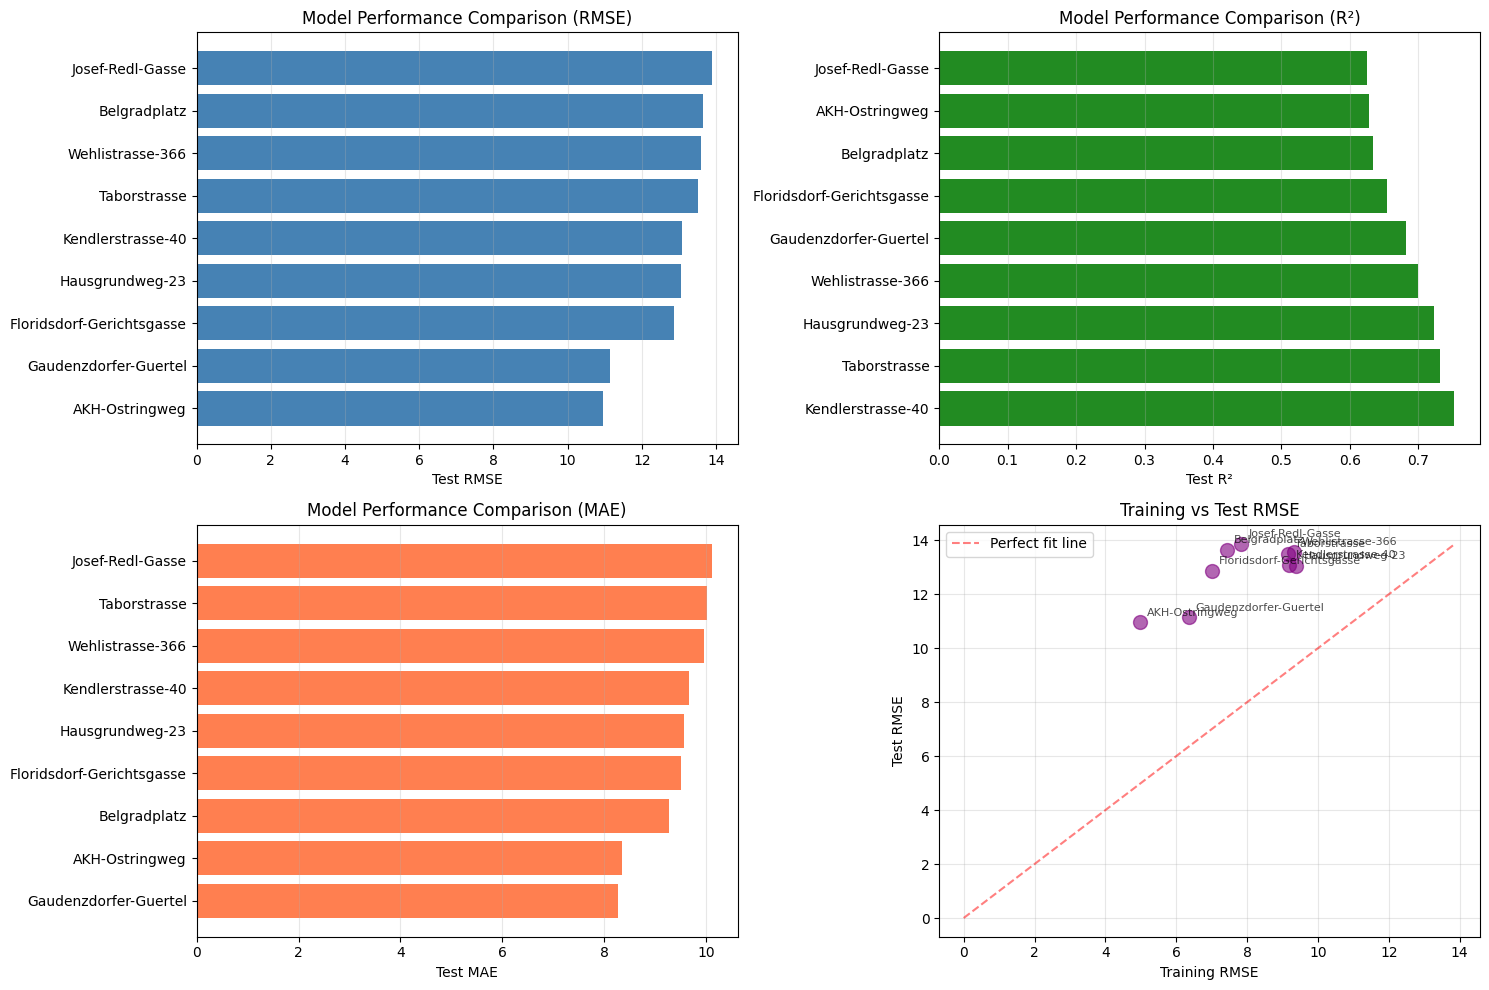

✅ Performance comparison plot saved: /Users/mac/Documents/Documents/ID2223_Scalable/lab1_new/Air_Quality_Prediction/notebooks/airquality/vienna_models/images/models_performance_comparison.png


In [8]:
# Visualize model performance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Test RMSE comparison
ax1 = axes[0, 0]
summary_df_sorted = summary_df.sort_values('rmse_test')
ax1.barh(summary_df_sorted['sensor_street'], summary_df_sorted['rmse_test'], color='steelblue')
ax1.set_xlabel('Test RMSE')
ax1.set_title('Model Performance Comparison (RMSE)')
ax1.grid(True, alpha=0.3, axis='x')

# Plot 2: Test R² comparison
ax2 = axes[0, 1]
summary_df_sorted = summary_df.sort_values('r2_test', ascending=False)
ax2.barh(summary_df_sorted['sensor_street'], summary_df_sorted['r2_test'], color='forestgreen')
ax2.set_xlabel('Test R²')
ax2.set_title('Model Performance Comparison (R²)')
ax2.grid(True, alpha=0.3, axis='x')

# Plot 3: Test MAE comparison
ax3 = axes[1, 0]
summary_df_sorted = summary_df.sort_values('mae_test')
ax3.barh(summary_df_sorted['sensor_street'], summary_df_sorted['mae_test'], color='coral')
ax3.set_xlabel('Test MAE')
ax3.set_title('Model Performance Comparison (MAE)')
ax3.grid(True, alpha=0.3, axis='x')

# Plot 4: Training vs Test RMSE
ax4 = axes[1, 1]
x = range(len(summary_df))
ax4.scatter(summary_df['rmse_train'], summary_df['rmse_test'], s=100, alpha=0.6, color='purple')
ax4.plot([0, summary_df[['rmse_train', 'rmse_test']].max().max()],
         [0, summary_df[['rmse_train', 'rmse_test']].max().max()],
         'r--', alpha=0.5, label='Perfect fit line')
ax4.set_xlabel('Training RMSE')
ax4.set_ylabel('Test RMSE')
ax4.set_title('Training vs Test RMSE')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Add sensor labels to scatter plot
for idx, row in summary_df.iterrows():
    ax4.annotate(row['sensor_street'], 
                (row['rmse_train'], row['rmse_test']),
                fontsize=8, alpha=0.7, 
                xytext=(5, 5), textcoords='offset points')

plt.tight_layout()
comparison_path = base_images_dir / "models_performance_comparison.png"
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Performance comparison plot saved: {comparison_path}")


---

## <span style="color:#ff5f27;"> 🎉 Training Pipeline Complete! </span>

### ✅ Summary of Accomplishments:

1. **Models Trained**: {len(all_models_results)} independent enhanced models
2. **Feature Engineering**: Added 3-day lagged PM2.5 features for each sensor
3. **Feature Groups Created**: One per sensor with lagged features
4. **Feature Views Created**: One per sensor linking weather + lagged features
5. **Models Saved**: 
   - Local storage in `vienna_models/` directory
   - Hopsworks Model Registry
6. **Visualizations Generated**:
   - Feature importance plots (9 sensors)
   - Prediction comparison plots (9 sensors)  
   - Overall performance comparison plot

### 📊 Model Performance:
- Average Test RMSE across all sensors
- Each model uses weather features + 3-day lagged PM2.5
- All models stored in Hopsworks Model Registry for deployment

### 📁 Artifacts Location:
- **Models**: `{base_model_dir}/`
- **Images**: `{base_images_dir}/`
- **Summary**: `{base_model_dir}/training_summary.csv`

### ⏭️ Next Steps:
1. Run **batch inference pipeline** to generate predictions for all sensors
2. Create **dashboard** to visualize predictions across Vienna
3. Deploy models for **real-time predictions**

---
